In [ ]:
!pip install demoji
!pip install WordCloud
!pip install pyLDAvis

# Basic
import numpy as np
import pandas as pd

# Data Cleaning
import re
import string
import demoji
demoji.download_codes()

# Data Pre-processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS



... OK (Got response in 0.12 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Buidling the LDA model
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim
import pyLDAvis.sklearn
from sklearn.model_selection import *
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Master - Classes/CIS 9665 - NLP/NLP Group Project/DATASET/20201117_230813_covid_tweets_50000.csv')
df.head(5)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291,733,7374,2008-09-18 01:08:47,2020-11-17 18:07:31,137,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]"
1,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168,23749,18951,2009-01-17 06:58:29,2020-11-17 18:07:31,0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]"
2,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284,376,5078,2013-12-05 14:03:36,2020-11-17 18:07:31,0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]"
3,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633,30489,57043,2007-06-05 14:47:23,2020-11-17 18:07:31,0,The area of arctic sea ice that didn't melt be...,[]
4,JoelJeffcoat,NaN,NaN,293,113,19637,2017-04-18 18:30:24,2020-11-17 18:07:31,30,This is where we are. CEOs of the American Hos...,[]


In [ ]:
df2=pd.DataFrame(df["text"].unique()).reset_index().drop('index',axis=1)

df2.columns=['text']

# Data Preprocessing

In [ ]:
punct=string.punctuation+'”‘’“'
stopwords = nltk.corpus.stopwords.words("english")
custom_stopwords = ['hi', '&amp;', 'amp', 'amp;', 'got', "it's", 'it’s', "i'm", 'im', 'want', 'like', '$', '@','-', 'covid','coronavirus','covid19','covid-19','u', "U"]
for i in custom_stopwords:
    stopwords.append(i)

In [ ]:
def data_processing(text):

    # Remove URL
    url = re.compile(r'http\S+')
    text=url.sub(r'',text)

    # Remove html tags
    html=re.compile(r'<.*?>')
    text=html.sub(r'',text)
    
    # Remove emojis
    text = demoji.replace(text, "")
    
    # Remove mentions and hashtag
    text=re.sub(r'@\w+','',text)        # remove mentions
    text=re.sub(r'#\w+','',text)        # remove hashtag
    
    # Remove Emails
    email = re.compile(r'\S*@\S*\s?')
    text=email.sub(r'', text)
    
    # Remove new line characters
    newline = re.compile(r'\n+')
    text=newline.sub(r'', text)
    
    # Remove extra white space left while removing stuff
    whitespace_remove = re.compile(r'\s+')
    text=whitespace_remove.sub(r' ', text)
    
    # Make text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punct), '', text)    

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove stopwords
    text=" ".join(word for word in str(text).split() if word not in stopwords)
    
    # Tokenization
    text=word_tokenize(text)
    
    # Lemmatization
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [ ]:
tweets_df_clean = pd.DataFrame(df2["text"].apply(lambda x: data_processing(x)))

In [ ]:
tweets_df_clean.text

0        [new, signed, executive, order, lower, limit, ...
1        [dutch, bar, cafe, restaurant, remain, closed,...
2                                        [happy, birthday]
3        [area, arctic, sea, ice, didnt, melt, beacuse,...
4        [ceo, american, hospital, association, america...
                               ...                        
23640    [happening, biden, harris, met, ceo, microsoft...
23641       [way, make, thanksgiving, special, –, despite]
23642    [sa, research, showed, number, uk, customer, b...
23643    [premier, doug, ford, went, defensive, today, ...
23644    [due, giving, tree, going, virtual, accepting,...
Name: text, Length: 23645, dtype: object

##### Hashtags cleaning 

In [ ]:
hashtags_clean = pd.DataFrame(df["hashtags"].apply(lambda x: data_processing(x)))

In [ ]:
extra = ["text", "index"]
hashtags = [word for hashtags in hashtags_clean["hashtags"] for word in hashtags if word not in extra]
fdist = nltk.FreqDist(hashtags)
fdist.most_common(30)

[('blood', 368),
 ('vaccine', 215),
 ('pandemic', 198),
 ('lockdown', 142),
 ('canadian', 111),
 ('tuesdayvibe', 106),
 ('trump', 106),
 ('wearamask', 78),
 ('maskup', 70),
 ('corona', 70),
 ('delhi', 66),
 ('healthcare', 63),
 ('staysafe', 57),
 ('covidvaccine', 55),
 ('bloodaid', 53),
 ('mouthwash', 50),
 ('stayhome', 50),
 ('health', 48),
 ('urgent', 47),
 ('moderna', 47),
 ('cdnpoli', 46),
 ('thanksgiving', 45),
 ('mask', 42),
 ('mentalhealth', 42),
 ('insidertraitors', 42),
 ('covidalert', 40),
 ('coronavirusuk', 40),
 ('kellyloeffler', 39),
 ('thegreatreset', 38),
 ('ai', 37)]

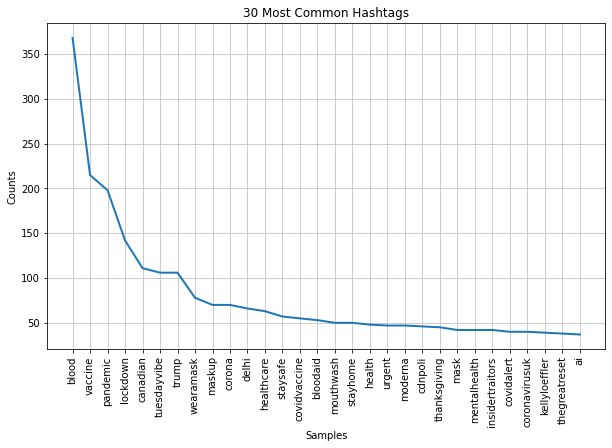

In [ ]:
fig = plt.figure(figsize = (10,6))
fdist.plot(30, cumulative=False, title = '30 Most Common Hashtags')
plt.show()

## Exploratory Analysis

### Tweets Character Length

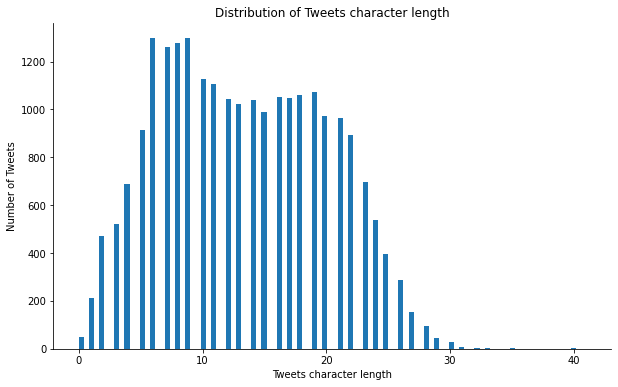

In [ ]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in tweets_df_clean.text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Tweets character length')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweets character length')
sns.despine();

### Wordcloud

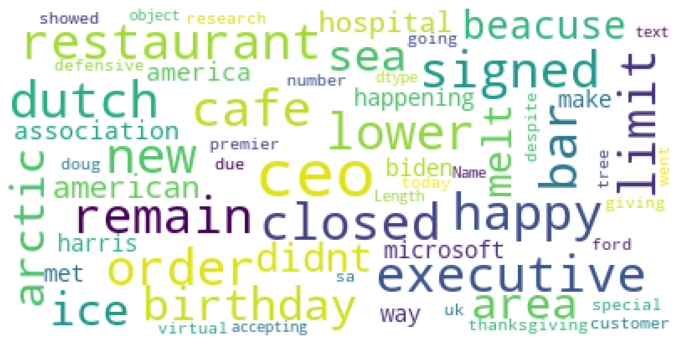

In [ ]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                      background_color='white',
                      stopwords=stopwords,
                      max_words=500,
                      max_font_size=40, 
                      random_state=100
                      ).generate(str(tweets_df_clean.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
# Flatten tweets
flat_list = [item for sublist in tweets_df_clean.text for item in sublist]

from sklearn.feature_extraction.text import CountVectorizer

# CountVectorize
vectorizer = CountVectorizer(
                            analyzer='word',       
                            min_df=3, # minimum required occurences of a word 
                            token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
                            max_features=5000, # max number of unique words
                            )
data_matrix = vectorizer.fit_transform(flat_list)

# The 10 most common words
sum_words = data_matrix.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:20]

[('case', 2707),
 ('people', 2258),
 ('new', 2198),
 ('vaccine', 2085),
 ('pandemic', 1772),
 ('health', 1438),
 ('death', 1317),
 ('need', 1185),
 ('one', 1160),
 ('test', 1118),
 ('get', 1115),
 ('time', 1074),
 ('today', 1072),
 ('mask', 1056),
 ('help', 1041),
 ('say', 1023),
 ('year', 1002),
 ('day', 963),
 ('state', 941),
 ('via', 928)]

-------
# Building the LDA model
#### Baseline model using K = 10

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model = LdaMulticore(
                          num_topics = 10, # Number of topics        
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )

In [ ]:
# Print the Keyword in the 10 topics
print("Topics found via LDA:")
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

Topics found via LDA:
[(0,
  '0.018*"testing" + 0.011*"health" + 0.009*"worker" + 0.008*"free" + '
  '0.008*"information" + 0.007*"test" + 0.007*"care" + 0.006*"need" + '
  '0.006*"get" + 0.005*"community"'),
 (1,
  '0.010*"home" + 0.007*"lockdown" + 0.006*"student" + 0.005*"u" + '
  '0.005*"government" + 0.005*"continue" + 0.005*"case" + 0.004*"due" + '
  '0.004*"contract" + 0.004*"disease"'),
 (2,
  '0.023*"people" + 0.014*"mask" + 0.011*"get" + 0.010*"dont" + 0.010*"say" + '
  '0.009*"trump" + 0.008*"one" + 0.008*"patient" + 0.008*"virus" + '
  '0.007*"still"'),
 (3,
  '0.020*"show" + 0.014*"sign" + 0.012*"need" + 0.011*"promising" + '
  '0.011*"mouthwash" + 0.011*"test" + 0.009*"reducing" + 0.009*"research" + '
  '0.008*"ingredient" + 0.008*"saliva"'),
 (4,
  '0.009*"pandemic" + 0.009*"help" + 0.008*"safe" + 0.008*"business" + '
  '0.008*"spread" + 0.007*"new" + 0.007*"family" + 0.007*"stay" + 0.007*"keep" '
  '+ 0.006*"holiday"'),
 (5,
  '0.014*"pandemic" + 0.012*"health" + 0.011*

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.107885 -0.020146       1        1  17.070351
4      0.174583 -0.017999       2        1  16.124640
9     -0.113952  0.285059       3        1  12.037722
0      0.110438  0.029331       4        1  10.710166
5      0.101166 -0.025995       5        1   9.841655
7      0.023059 -0.010580       6        1   8.917427
8      0.043079 -0.123518       7        1   7.486632
1     -0.056792  0.065823       8        1   6.599329
6     -0.136496  0.003935       9        1   6.488437
3     -0.252970 -0.185910      10        1   4.723641, topic_info=            Term         Freq        Total Category  logprob  loglift
139         case  2563.000000  2563.000000  Default  30.0000  30.0000
61       vaccine  1905.000000  1905.000000  Default  29.0000  29.0000
141        death  1182.000000  1182.000000  Default  28.0000  28.0000
37          year   857.000000   857.000000  Default  27.0000  27.0000
7            new  2081.000000  2081.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2398        unit    44.406036    92.320498  Topic10  -5.8199   2.3207
599       number    68.304721   576.568592  Topic10  -5.3893   0.9195
6577  management    39.605654    79.664183  Topic10  -5.9343   2.3537
146          via    49.637947   890.613497  Topic10  -5.7085   0.1654
10        people    51.139372  2034.764408  Topic10  -5.6787  -0.6310

[666 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
7343      9  0.971085  accelerated
3100      2  0.021711    according
3100      3  0.564486    according
3100      6  0.091186    according
3100     10  0.316981    according
...     ...       ...          ...
747       7  0.073731            –
747       8  0.029045            –
747      10  0.020108            –
3690      8  0.984316            •
5017      7  0.995470           ⁦⁩

[1430 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 10, 1, 6, 8, 9, 2, 7, 4])

## Selecting the best number of topics (K)

### k=4

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 4, # Number of topics        
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )


In [ ]:
# Print the Keyword in the 4 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.009*"health" + 0.009*"help" + 0.006*"testing" + 0.006*"spread" + '
  '0.006*"get" + 0.005*"need" + 0.005*"please" + 0.005*"home" + 0.005*"family" '
  '+ 0.005*"community"'),
 (1,
  '0.036*"case" + 0.022*"new" + 0.014*"death" + 0.011*"test" + '
  '0.011*"positive" + 0.010*"state" + 0.008*"county" + 0.007*"today" + '
  '0.007*"week" + 0.007*"number"'),
 (2,
  '0.019*"vaccine" + 0.014*"people" + 0.008*"mask" + 0.007*"say" + 0.006*"one" '
  '+ 0.006*"get" + 0.006*"dont" + 0.005*"u" + 0.005*"trump" + 0.005*"make"'),
 (3,
  '0.013*"pandemic" + 0.006*"impact" + 0.005*"join" + 0.005*"new" + '
  '0.005*"show" + 0.005*"u" + 0.004*"need" + 0.004*"read" + 0.004*"challenge" '
  '+ 0.004*"research"')]


### k=5

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 5, # Number of topics          
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )


In [ ]:
# Print the Keyword in the 5 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.010*"testing" + 0.009*"health" + 0.006*"trump" + 0.006*"worker" + '
  '0.005*"vaccine" + 0.005*"help" + 0.005*"community" + 0.004*"call" + '
  '0.004*"need" + 0.004*"get"'),
 (1,
  '0.042*"case" + 0.022*"new" + 0.016*"death" + 0.012*"positive" + '
  '0.011*"test" + 0.010*"state" + 0.009*"county" + 0.008*"number" + '
  '0.008*"today" + 0.007*"week"'),
 (2,
  '0.021*"vaccine" + 0.016*"people" + 0.009*"mask" + 0.008*"say" + 0.007*"get" '
  '+ 0.007*"one" + 0.006*"dont" + 0.006*"u" + 0.005*"virus" + 0.005*"patient"'),
 (3,
  '0.010*"pandemic" + 0.008*"join" + 0.008*"show" + 0.007*"test" + 0.006*"u" + '
  '0.006*"sign" + 0.005*"research" + 0.005*"discus" + 0.005*"need" + '
  '0.005*"impact"'),
 (4,
  '0.009*"pandemic" + 0.007*"help" + 0.007*"health" + 0.006*"new" + '
  '0.006*"business" + 0.006*"spread" + 0.005*"safe" + 0.005*"make" + '
  '0.005*"time" + 0.005*"home"')]


### k=6

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 6, # Number of topics         
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )

In [ ]:
# Print the Keyword in the 6 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.013*"testing" + 0.009*"trump" + 0.006*"worker" + 0.006*"health" + '
  '0.005*"get" + 0.005*"community" + 0.005*"vaccine" + 0.005*"help" + '
  '0.005*"test" + 0.005*"free"'),
 (1,
  '0.047*"case" + 0.025*"new" + 0.019*"death" + 0.014*"test" + '
  '0.014*"positive" + 0.010*"state" + 0.010*"county" + 0.009*"number" + '
  '0.008*"week" + 0.008*"today"'),
 (2,
  '0.023*"vaccine" + 0.017*"people" + 0.008*"say" + 0.008*"mask" + 0.007*"one" '
  '+ 0.007*"get" + 0.006*"u" + 0.006*"dont" + 0.006*"virus" + 0.006*"patient"'),
 (3,
  '0.012*"show" + 0.008*"need" + 0.008*"pandemic" + 0.007*"sign" + '
  '0.007*"research" + 0.006*"promising" + 0.006*"mouthwash" + 0.006*"test" + '
  '0.005*"reducing" + 0.005*"ingredient"'),
 (4,
  '0.008*"pandemic" + 0.008*"help" + 0.007*"new" + 0.006*"business" + '
  '0.006*"safe" + 0.005*"time" + 0.005*"people" + 0.005*"spread" + 0.005*"way" '
  '+ 0.005*"make"'),
 (5,
  '0.010*"health" + 0.008*"join" + 0.008*"impact" + 0.008*"u" + '
 

### k=7

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 7, # Number of topics          
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )

In [ ]:
# Print the Keyword in the 7 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.011*"testing" + 0.010*"health" + 0.008*"need" + 0.008*"worker" + '
  '0.006*"pandemic" + 0.006*"help" + 0.006*"test" + 0.005*"support" + '
  '0.005*"care" + 0.005*"get"'),
 (1,
  '0.049*"case" + 0.029*"new" + 0.020*"death" + 0.016*"test" + '
  '0.015*"positive" + 0.011*"state" + 0.010*"number" + 0.010*"county" + '
  '0.009*"week" + 0.008*"rate"'),
 (2,
  '0.025*"vaccine" + 0.018*"people" + 0.010*"mask" + 0.009*"trump" + '
  '0.009*"say" + 0.007*"u" + 0.007*"get" + 0.007*"dont" + 0.006*"one" + '
  '0.006*"american"'),
 (3,
  '0.015*"show" + 0.011*"sign" + 0.008*"need" + 0.008*"mouthwash" + '
  '0.008*"pandemic" + 0.007*"promising" + 0.006*"research" + 0.006*"reducing" '
  '+ 0.006*"ingredient" + 0.006*"saliva"'),
 (4,
  '0.008*"new" + 0.008*"spread" + 0.007*"pandemic" + 0.007*"help" + '
  '0.007*"thanksgiving" + 0.006*"make" + 0.006*"way" + 0.006*"safe" + '
  '0.006*"home" + 0.006*"time"'),
 (5,
  '0.010*"pandemic" + 0.010*"u" + 0.009*"impact" + 0.009*"jo

----


## Rename 7 Topics

In [ ]:
topics={0:'Back-to-School',1:'COVID B-Day',2:'New Cases',3:'Climate Change',4:'Vaccine Research',5:'Covid Protection',6:'Thanksgiving Gathering'}

In [ ]:
def get_topic(tweet):

    tokens = data_processing(tweet)
    result=lda_model_2[id2word.doc2bow(tokens)][0]
    
    d={}
    
    for i in result:
        d[i[0]]=i[1]
    
    key=max(d, key=d.get)
    
    return topics[key]
    


In [ ]:
test2=df2

test2['topic']= ''

test2.loc[:, 'clean']=test2['text'].apply(lambda x: data_processing(x))

test2.loc[:, 'topic']=test2['text'].apply(lambda x: get_topic(x))

test2.to_csv('result.csv')

In [ ]:
test2

,text,topic,clean
0,NEW: I just signed an Executive Order to lower...,Vaccine Research,"[new, signed, executive, order, lower, limit, ..."
1,"Dutch bars, cafes and restaurants will remain ...",Vaccine Research,"[dutch, bar, cafe, restaurant, will, remain, c..."
2,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,Thanksgiving Gathering,"[happy, birthday]"
3,The area of arctic sea ice that didn't melt be...,Climate Change,"[area, arctic, sea, ice, didnt, melt, beacuse,..."
4,This is where we are. CEOs of the American Hos...,Back-to-School,"[ceo, american, hospital, association, america..."
...,...,...,...
23640,Happening Now: Biden and Harris met with the C...,Climate Change,"[happening, now, biden, harris, met, ceo, micr..."
23641,Here are 7 ways to make Thanksgiving 2020 spec...,Vaccine Research,"[way, make, thanksgiving, special, –, despite]"
23642,SAS' #EX2030 research showed that the number o...,Vaccine Research,"[sa, research, showed, number, uk, customer, b..."
23643,Premier Doug Ford went on the defensive today ...,Covid Protection,"[premier, doug, ford, went, defensive, today, ..."


In [ ]:
new_text = 'Prevent the spread of the virus by washing your hand regularly and wearing your nose mask'
tokens = [token for token in word_tokenize(new_text.lower())]
result=lda_model_2[id2word.doc2bow(tokens)]
result[0]

[(0, 0.014306971),
 (1, 0.014295864),
 (2, 0.3373654),
 (3, 0.09945913),
 (4, 0.5059839),
 (5, 0.014303074),
 (6, 0.014285724)]

In [ ]:
# Compute Perplexity 
base_perplexity = lda_model_2.log_perplexity(corpus)
print("\nPerplexity: ", base_perplexity)

# Compute Coherence Score
coherence_model = CoherenceModel(model = lda_model_2, texts = tweets_df_clean["text"],
                                 coherence = "c_v")
coherence_lda_model_base = coherence_model.get_coherence()
print("\nCoherence Score: ", coherence_lda_model_base)


Perplexity:  -8.598989030698135

Coherence Score:  0.4148533601970697


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.142374 -0.003952       1        1  22.537850
4      0.131552  0.072006       2        1  19.337660
1     -0.015417 -0.235079       3        1  15.600325
0      0.070832  0.096170       4        1  14.786899
5      0.016072  0.125816       5        1  11.772240
6     -0.054930 -0.158493       6        1   8.930594
3     -0.290482  0.103531       7        1   7.034432, topic_info=           Term         Freq        Total Category  logprob  loglift
139        case  2549.000000  2549.000000  Default  30.0000  30.0000
61      vaccine  1951.000000  1951.000000  Default  29.0000  29.0000
7           new  2074.000000  2074.000000  Default  28.0000  28.0000
141       death  1178.000000  1178.000000  Default  27.0000  27.0000
143    positive   753.000000   753.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
599      number    67.251702   572.443450   Topic7  -5.8031   0.5129
160        read    63.052378   436.309456   Topic7  -5.8676   0.7200
146         via    59.014236   894.404054   Topic7  -5.9338  -0.0640
3100  according    56.404130   230.252290   Topic7  -5.9790   1.2477
521        news    56.542025   572.660052   Topic7  -5.9765   0.3390

[471 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3398      2  0.332795     access
3398      3  0.005456     access
3398      4  0.665591     access
3100      1  0.052117  according
3100      2  0.039088  according
...     ...       ...        ...
747       4  0.002222          –
747       5  0.120001          –
3690      3  0.981817          •
5017      1  0.228031         ⁦⁩
5017      6  0.768106         ⁦⁩

[922 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 6, 7, 4])

# Apply Sentiment
https://colab.research.google.com/drive/1N5t4WruXxeHtv4UOKgRjKKxof_2WOFgt?authuser=2